# Intro 

### Libraries

In [2]:
#Different libraries that we need 

import numpy as np # numerical python for operations on arrays, matrix
import pandas as pd # very efficient for handling databases 
import matplotlib.pyplot as plt # for graphs 
import glob # for accessing directories (where the data are)
from scipy import stats # scientific python - for special functions and probability densities 
import re # for regular expressions 
import math # for handgling with trigonometric functions 
from tqdm import tqdm_notebook as tqdm
import matplotlib.path as mplPath ## Create Shapes for zone of interest 

# in order to plot inline, Jupyter Notebook only 
%matplotlib notebook     

### Self-made functions

In [5]:
# We are using this function in order to get the food angle with respect to the center of the maze 
# To be short : polar coordinates angle from cartesian coordinates 
# We need this angle in order to perform vector arithmetic to get current position to food vector 

def angle_from_position(x_coordinate,y_coordinate):
    if math.degrees(math.atan2(x_coordinate, y_coordinate)) >= 0 : 
        return float("{0:.2f}".format(math.degrees(math.atan2(x_coordinate, y_coordinate)))) 
    else : 
        return (360 + float("{0:.2f}".format(math.degrees(math.atan2(x_coordinate, y_coordinate)))))


In [6]:
# Angle by cosine theorem (trygonometry) : actually rotated angle 
# Look at my notes
def rot_angle_cosine_theorem(side1, side2 ,side3, angle):
    return (angle + np.degrees(np.arccos((side2*side2 + side3*side3 - side1*side1 )/(2*side2*side3)))) 

## Importing Data from .csv files

In [7]:
# Import all the .csv files 
trackFiles = []
trackFiles = glob.glob('C:/Users/jamesjun/Desktop/Simone/Csv/ShuffleCsv/Track/*.csv')

shapeFiles = []
shapeFiles = glob.glob('C:/Users/jamesjun/Desktop/Simone/Csv/ShuffleCsv/Shapes/*.csv')

relationsFiles = []
relationsFiles = glob.glob('C:/Users/jamesjun/Desktop/Simone/Csv/ShuffleCsv/Relations/*.csv')

In [8]:
probeFiles = []

# Filtering probe trials 
# if probeFilter = True, probetrials are not used in the future statistics
# if probeFilter = False, probetrials are going to take part in the stats
probeFilter = True 

if probeFilter == True:
    regExpr = re.compile(r'p_Track')
    regExpr2 = re.compile(r'p_shape')
    regExpr3 = re.compile(r'p_relations')
    
    probeFiles = list(filter(lambda i : regExpr.search(i), trackFiles))
    probeShapesFiles = list(filter(lambda i : regExpr2.search(i), shapeFiles))
    probeRelationsFiles = list(filter(lambda i : regExpr3.search(i), relationsFiles))
    
    trackFiles = list(filter(lambda i : not regExpr.search(i), trackFiles))
    shapeFiles = list(filter(lambda i : not regExpr2.search(i), shapeFiles))
    relationsFiles = list(filter(lambda i : not regExpr3.search(i), relationsFiles))
    
    
else : 
    trackFiles = trackFiles 
    shapeFiles = shapeFiles
    relationsFiles = relationsFiles 


In [12]:
# Creating list of tracking Data as list of pandas dataframes 
trackData = []
for i in tqdm(range(0,len(trackFiles))) : 
    trackData.append(pd.read_csv(trackFiles[i], names = ["Time", "X", "Y", "HeadAngle","EODRate","DistanceXEODPulse",
                                                         "HeadSpeed", "DistanceXESCAN"]))
    """_Track.csv files:
    Columns: T(s), X(m), Y(m), A(deg), R(Hz), D(m), V(m/s), S(m):
    T: camera frame time
    X: x coordinate of the head tip @ grid frame of reference
    Y: y coordinate of the head tip @ grid frame of reference
    A: head orientation
    R: EOD rate
    D: Distance per EOD pulse (=1/sampling_density)
    V: Head speed (m/s, signed)
    S: Distance per Escan (=1/escan_density)"""
    


#Adding landmark name and color in order to create a new dataframe for shapes

landm_name = {'Shape': ['Triangle Lg', 'Triangle Sm',  'Square Lg', 'Square Sm', 'Circle Lg', 'Circle Sm', 'Food']} 
shape_names = pd.DataFrame(data = landm_name)

color_shapes = pd.DataFrame(data = np.linspace(0,1,7), columns= ['Color'])

shapeData = []
for i in tqdm(range(0,len(shapeFiles))) : 
    shapeData.append(pd.read_csv(shapeFiles[i], names = ["X", "Y", "Angle"]))
    shapeData[i] = pd.concat([shape_names,shapeData[i]], axis = 1)
    shapeData[i] = pd.concat([shapeData[i], color_shapes], axis = 1)
    
    """_shapes.csv files:
    Columns: X(m), Y(m), A(deg):
    X(m): x coordinate of the shape center @ grid frame of reference
    Y(m): y coordinate of the shape center @ grid frame of reference
    A(deg): Shape orientation
    Rows: "Triangle Lg", "Triangle Sm", "Square Lg", "Square Sm", "Circle Lg", "Circle Sm", "Food", """
    
    
relationsData = []
for i in tqdm(range(0,len(relationsFiles))) : 
    relationsData.append(pd.read_csv(relationsFiles[i], names = ["CameraFrameTime", "DistFood", "HeadAngleError", 
                                                                 "TriangleLg", "TriangleSm", "SquareLg", "SquareSm", "CircleLg"
                                                                , "CircleSm", "Food"]))

    """_relations.csv files:
       Columns: T(s), D_F(m), A_E(deg), L_"Triangle Lg"(bool), L_"Triangle Sm"(bool), L_"Square Lg"(bool), L_"Square Sm"(bool), L_"Circle Lg"(bool), L_"Circle Sm"(bool), L_"Food"(bool), 
       T: camera frame time
       D_F: distance to the food
       A_E: heading angle error (food_vec - head_vec, 0..90 deg)
       L_"x": Is shape "x" adjacent to the head position? 0:no, 1:yes"""

# Creating list of probe Data as list of pandas dataframes 
probeData = []
for i in tqdm(range(0,len(probeFiles))) : 
    probeData.append(pd.read_csv(probeFiles[i], names = ["Time", "X", "Y", "HeadAngle","EODRate","DistanceXEODPulse",
                                                         "HeadSpeed", "DistanceXESCAN"]))
    
probeShapeData = []
for i in tqdm(range(0,len(probeShapesFiles))) : 
    probeShapeData.append(pd.read_csv(probeShapesFiles[i], names = ["X", "Y", "Angle"]))
    probeShapeData[i] = pd.concat([shape_names, probeShapeData[i]], axis = 1)
    probeShapeData[i] = pd.concat([probeShapeData[i], color_shapes], axis = 1)
    

probeRelationsData = [] 
for i in tqdm(range(0,len(probeRelationsFiles))) : 
    probeRelationsData.append(pd.read_csv(probeRelationsFiles[i], names = ["CameraFrameTime", "DistFood", "HeadAngleError", 
                                                                 "TriangleLg", "TriangleSm", "SquareLg", "SquareSm", "CircleLg"
                                                                , "CircleSm", "Food"]))
    




In [13]:
#Quick consistency check 
len(trackData) == len(shapeData) ==len(relationsData)

True

# Plotting Trajectories 
### Plotting an Example trajectory (it can be done for every trajectory)

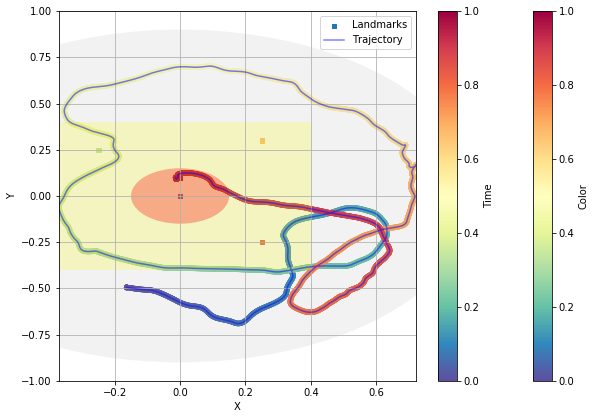

In [13]:
import matplotlib.patches as patches

#Select trajectory number (based on number of videos = 199 + 14(probes))
traj_number = 3



# Plotting each trajectory with Spectral colormap based on time --> as James did in matlab 
# The colormap is related to time --> take a look on the side of the plot 

#plt.figure()


fig, ax = plt.subplots()
circ = patches.Circle((0, 0), 0.9, alpha=0.10, fc='grey')
square = patches.Rectangle((-0.4,-0.4), 0.8, 0.8, alpha = 0.2, fc = 'yellow')
circ2 = patches.Circle((0, 0), 0.15, alpha=0.30, fc='red')

ax.add_patch(circ)
ax.add_patch(square)
ax.add_patch(circ2)


plt.xlim(-1,1)
plt.ylim(-1,1)
# Setting positions of landmarks and trajectory points 
shapeData[traj_number].plot.scatter(x = "X", y = 'Y',ax = ax, marker = 's', style = 'o', label = 'Landmarks', c = 'Color', cmap = 'Spectral_r')
trackData[traj_number].plot.scatter(x = "X", y = 'Y',ax = ax,c = 'Time', cmap = 'Spectral_r')

# Adding polygonal chain in order to see the trajectory and get vector length later 
trackData[traj_number].plot.line(x = "X", y = 'Y', ax = ax, style = 'b', alpha = 0.5, grid = True, figsize = (10,6.8), label = 'Trajectory')



## Probe Trials Filtering

Ok take a look! Probe trials trajectories are much more messy. We should cut them whenever the fish is close to the Large Triangle shape. 

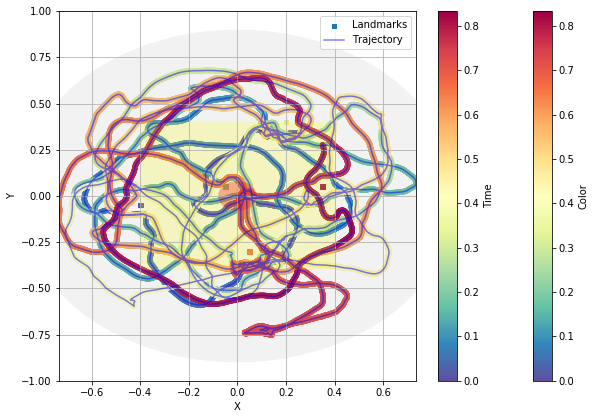

In [16]:
import matplotlib.patches as patches

#Select trajectory number (based on number of videos = 199 + 14(probes))
traj_number = 0



# Plotting each trajectory with Spectral colormap based on time --> as James did in matlab 
# The colormap is related to time --> take a look on the side of the plot 

#plt.figure()


fig, ax = plt.subplots()
circ = patches.Circle((0, 0), 0.9, alpha=0.10, fc='grey')
square = patches.Rectangle((-0.4,-0.4), 0.8, 0.8, alpha = 0.2, fc = 'yellow')
circ2 = patches.Circle((0, 0), 0.08, alpha=0.30, fc='red')

ax.add_patch(circ)
ax.add_patch(square)
ax.add_patch(circ2)

plt.xlim(-1,1)
plt.ylim(-1,1)
# Setting positions of landmarks and trajectory points 
probeShapeData[traj_number].plot.scatter(x = "X", y = 'Y',ax = ax, marker = 's', style = 'o', label = 'Landmarks', c = 'Color', cmap = 'Spectral_r')
probeData[traj_number].plot.scatter(x = "X", y = 'Y',ax = ax,c = 'Time', cmap = 'Spectral_r')

# Adding polygonal chain in order to see the trajectory and get vector length later 
probeData[traj_number].plot.line(x = "X", y = 'Y', ax = ax, style = 'b', alpha = 0.5, grid = True, figsize = (10,6.8), label = 'Trajectory')

plt.show()

In [62]:
# Ok so far : Triangle LG (pos : X = 0, Y = 0) is the shape associated to food, we can draw a circle around it 
# And get when the fish is approacing to that shape, in this way we can extract the filtered probe trials 

radius = 0.04 # We should decide whether this is a good candidate as a value 
x_pos_vertex = []
y_pos_vertex = [] 
number_of_vertices = 1000 # 1000 Are enough to get a good result in approximation 


for m in tqdm(range(0, number_of_vertices)) : 
    x_pos_vertex.append(radius * np.cos(2*m *np.pi/number_of_vertices  ))
    y_pos_vertex.append(radius * np.sin(2*m *np.pi/number_of_vertices  ))

x_pos_vertex = np.asarray(x_pos_vertex)
y_pos_vertex = np.asarray(y_pos_vertex)
vertex_coordinates = np.vstack((x_pos_vertex, y_pos_vertex)).T

In [17]:
probeShapeData[0]

,Shape,X,Y,Angle,Color
0,Triangle Lg,-0.40,-0.05,0,0.000000
1,Triangle Sm,-0.05,0.05,0,0.166667
2,Square Lg,0.20,0.40,0,0.333333
3,Square Sm,NaN,NaN,0,0.500000
4,Circle Lg,0.05,-0.30,0,0.666667
5,Circle Sm,0.35,0.05,0,0.833333
6,Food,NaN,NaN,0,1.000000


In [ ]:
def circle_around_food(index_shapeData):
    """Returns food mask coordinates"""
    radius_food = 0.0
     
    radius_food_mask = radius_food + 0.04 # 4 cm check on Jun et Al. paper

    x_pos_vertex = []
    y_pos_vertex = [] 
    number_of_vertices = 1000 # 1000 Are enough to get a good approximate result 


    for m in range(0, number_of_vertices) : 
        x_pos_vertex.append(np.cos(2*m *np.pi/number_of_vertices  ))
        y_pos_vertex.append(np.sin(2*m *np.pi/number_of_vertices  ))

    x_pos_vertex = np.asarray(x_pos_vertex)
    y_pos_vertex = np.asarray(y_pos_vertex)

    x0_food = shapeData[index_shapeData].iloc[6,1]
    y0_food = shapeData[index_shapeData].iloc[6,2]

    x_pos_vertex_food_mask = radius_food_mask*x_pos_vertex + x0_food
    y_pos_vertex_food_mask = radius_food_mask*y_pos_vertex + y0_food

    vertex_coordinates_food_mask = np.vstack((x_pos_vertex_food_mask, y_pos_vertex_food_mask)).T
    
    return vertex_coordinates_food_mask


In [63]:
#Defining a circle approximation as a polygon in order to get 
polygon_circle_approx = vertex_coordinates# poly
circlePath = mplPath.Path(polygon_circle_approx)

In [64]:
r = 0.001 # accuracy

FoodZoneList = []
for i in tqdm(range(0,len(probeData))):
    pnts = probeData[i].drop(columns = ['Time','HeadAngle',"EODRate","DistanceXEODPulse",
                                                         "HeadSpeed", "DistanceXESCAN"]).values # points on edges
    isIn = [circlePath.contains_point(pnt,radius=r) or circlePath.contains_point(pnt,radius=-r) for pnt in pnts]
    ArrayIsIn = np.asarray(isIn)
    df = pd.DataFrame(data = ArrayIsIn)
    df.columns = ['ActiveZoneFood']
    FoodZoneList.append(df)

In [ ]:
probeDa

In [65]:
filtering_index = []
for i in tqdm(range(0, len(probeData))):
    if len(FoodZoneList[i].index[FoodZoneList[i]["ActiveZoneFood"] == True].tolist()) > 0: 
        filtering_index.append(FoodZoneList[i].index[FoodZoneList[i]["ActiveZoneFood"] == True].tolist()[0])
    elif len(FoodZoneList[i].index[FoodZoneList[i]["ActiveZoneFood"] == True].tolist()) == 0: 
        filtering_index.append(len(FoodZoneList[i]) - 1)
    
    
filtering_index = np.asarray(filtering_index)

In [66]:
filtered_probe_track = [] 
filtered_probe_relations = []

for i in tqdm(range(0, len(probeData))):
    filtered_probe_track.append(probeData[i].truncate(after = filtering_index[i]))
    filtered_probe_relations.append(probeRelationsData[i].truncate(after = filtering_index[i]))

    

Exporting filtered Probe Files 

In [67]:
for i in tqdm(range(0,len(probeData))) : 
    pivot_df = pd.DataFrame(data = filtered_probe[i])
    pivot_rel_df = pd.DataFrame(data = filtered_probe_relations[i])
    
    pivot_df.to_csv("filteredProbeFiles/Track/filteredProbe"+str(i)+".csv", index = False )
    pivot_rel_df.to_csv("filteredProbeFiles/Relations/filteredRelationsProbe"+str(i)+".csv", index = False)

## Active Zone Analysis -- Decision Points ??? 

In [10]:
#Defining square in order to get when the fish is inside the interests zone 
square = np.array([[-0.4,-0.4], [-0.4,0.4], [0.4,0.4], [0.4,-0.4]])# poly
squarePath = mplPath.Path(square)

In [11]:
r = 0.001 # accuracy

ActiveZoneList = []
for i in tqdm(range(0,len(trackData))):
    pnts = trackData[i].drop(columns = ['Time','HeadAngle']).values # points on edges
    isIn = [ squarePath.contains_point(pnt,radius=r) or squarePath.contains_point(pnt,radius=-r) for pnt in pnts]
    ArrayIsIn = np.asarray(isIn)
    df = pd.DataFrame(data = ArrayIsIn)
    df.columns = ['ActiveZone']
    ActiveZoneList.append(df)

In [12]:
# Index of first position inside the zone of interest 
# We're gonna use it to get new trackData dataframes filtered from the first 
# position into zone of interest 
indexFilter = [] 
for i in range(0,len(ActiveZoneList)):
    indexFilter.append(ActiveZoneList[i].index[ActiveZoneList[i]['ActiveZone'] == True].tolist()[0])

In [13]:
# new dataframe with first position filtered
# N.B index reset 
DecisionData = []
for i in range(0,len(trackData)):
    DecisionData.append(trackData[i].iloc[indexFilter[i]:-1])
    DecisionData[i] = DecisionData[i].reset_index(drop = True)